In [1]:
import jax
import jax.numpy as jnp
from jax import lax
from collections import defaultdict
from jax import random
from tqdm import tqdm
from typing import Any, Callable

import matplotlib.pyplot as plt

In [6]:
def rms(true_values: jax.Array, estimated_values: jax.Array) -> jax.Array:
    return jnp.sqrt(jnp.mean(jnp.square(true_values - estimated_values)))
    
def td_update(
    values: jax.Array,
    alpha: float,
    gamma: float,
    reward: jax.Array,
    next_value: jax.Array,
    current_state: int,
) -> jax.Array:
    return values.at[current_state].add(
        alpha * (reward + gamma * next_value - values[current_state])
    )


def update_values(
    key,
    values: jax.Array,
    rewards: jax.Array,
    update_fn: Callable[
        [jax.Array, float, float, jax.Array, jax.Array, int], jax.Array
    ],
    alpha: float = 0.1,
    gamma = 1.0,
):

    done = False
    state = 3
    trajectory = []
    rews = []

    while not done:

        key, subkey = random.split(key)
        action = random.bernoulli(subkey, 0.5)

        next_state = state - 1 if action.item() is False else state + 1
        reward = rewards[next_state]

        trajectory.append(state)
        rews.append(reward)

        values = update_fn(values, alpha, gamma, reward, values[next_state], state)

        state = next_state

        if state == 6 or state == 0:
            done = True

    return values, trajectory, rews

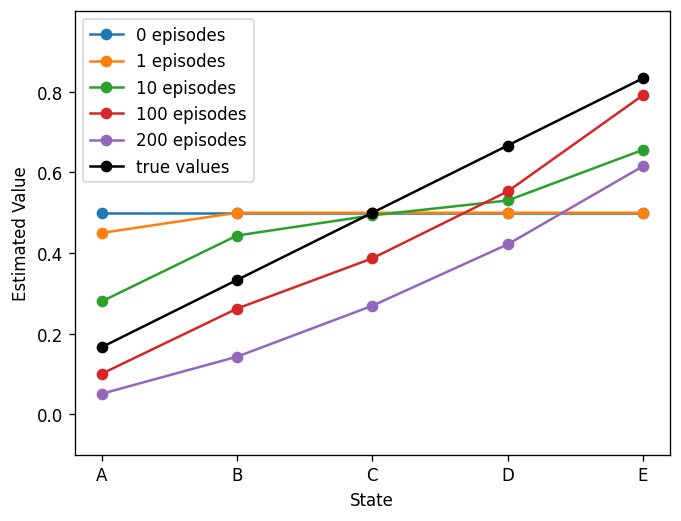

In [10]:
def experiment_6_2_left():

    n_states = 7  # 5 + 2 terminal states
    true_values = jnp.full(n_states, fill_value=1.0 / 6, dtype=jnp.float32)
    true_values = true_values.at[0].set(0.0)
    true_values = true_values.at[6].set(1.0)
    true_values = true_values.at[1:6].multiply(jnp.arange(5) + 1)

    rewards = jnp.zeros_like(true_values)
    rewards = rewards.at[6].set(1.0)

    assert jnp.allclose(
        true_values, jnp.array((0, 1.0 / 6, 2.0 / 6, 3.0 / 6, 4.0 / 6, 5.0 / 6, 1.0))
    ), f"true values: {true_values} are wrong!"
    
    values = jnp.full(n_states, 0.5)
    values = values.at[jnp.array((0, 6))].set(0.0)
    
    key = random.PRNGKey(0)
    
    plt.figure(1, dpi=120)
    plt.ylim(-0.1, 1.0)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    plt.gca().set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8"])
    
    log_episodes = [0, 1, 10, 100, 200]
    
    for i in range(log_episodes[-1] + 1):
        if i in log_episodes:
            plt.plot(
                ("A", "B", "C", "D", "E"),
                values[1:6],
                label=str(i) + " episodes",
                marker="o",
            )
        key, subkey = random.split(key)
        values, trajectory, rews = update_values(
            key, values=values, rewards=rewards, update_fn=td_update
        )
    plt.plot(
        ("A", "B", "C", "D", "E"),
        true_values[1:6],
        label="true values",
        c="black",
        marker="o",
    )
    plt.xlabel("State")
    plt.ylabel("Estimated Value")
    plt.legend();
    
experiment_6_2_left()

In [19]:
rms_step_sizes = {
    0.05: [],
    0.1: [],
    0.15: [],
}

N_RUNS = 100
N_EP = 100
N_S = 7

true_values = jnp.full(N_S, fill_value=1.0 / 6, dtype=jnp.float32)
true_values = true_values.at[0].set(0.0)
true_values = true_values.at[6].set(1.0)
true_values = true_values.at[1:6].multiply(jnp.arange(5) + 1)

rewards = jnp.zeros_like(true_values)
rewards = rewards.at[6].set(1.0)

for alpha in rms_step_sizes:
    for run in tqdm(range(N_RUNS)):
        # initialize approx value function
        values = jnp.full(N_S, 0.5)
        values = values.at[jnp.array((0, 6))].set(0.0)

        # initialize random generator
        key = random.PRNGKey(run)
        
        rms_step_sizes[alpha].append([])
        for ep in range(N_EP):
            key, _ = random.split(key)
            rms_step_sizes[alpha][run].append(rms(true_values[1:6], values[1:6]))
            values, trajectory, rews = update_values(
                key, values=values, rewards=rewards, update_fn=td_update, alpha=alpha
            )

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


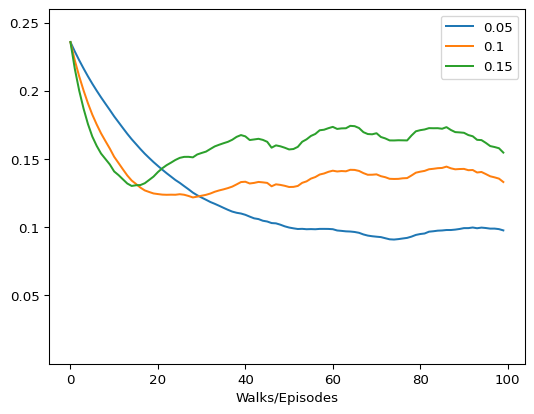

In [22]:
plt.figure(1, dpi=96)
plt.ylim(0., 0.26)
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.gca().set_yticklabels(["0.05", "0.1", "0.15", "0.2", "0.25"])

for k, v in rms_step_sizes.items():
    plt.plot(jnp.array(rms_step_sizes[k]).mean(axis=0), label=f"{k}")
plt.xlabel("Walks/Episodes")
plt.legend();